#Projet Poppy-torso : Distinguer la dureté des objets

**Importation des librairies :**
- Librairie poppy.creatures pour commander le robot PoppyTorso
- Librairie time pour gérer le temps
- Librairie maths pour les calculs trigonométriques
- Librairie numpy pour les matrices
- Librairie primitive pour lancer des tâches en arrière plan

In [1]:
from poppy.creatures import PoppyTorso
from pypot.primitive import Primitive

In [2]:
import time
import math as mt
import numpy as np

Définition des classes servant à faire des calculs pour que les mains atteingnent l'objet à tester.
Les algorythmes utilisent, le **thérorème d'Al-akshi**, les **matrices homogènes de transformations** dans l'espace pour une chaine de moteurs, les **produits vectoriels et scalaires** afin de déterminer des angles entre vecteurs. 
Voir le document annexe pour une définition plus précise des concepts mathématiques mis en oeuvre.

In [26]:
def timeit(method):

    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print "temps d'éxécution :",te-ts
        
        return result

    return timed

def Rx(a):
    #Matrice de transformation homogène  pour une rotatin autour de l'axe x
    a = mt.radians(a)
    Rx = np.mat([[1,0,0,0],
               [0,mt.cos(a),-mt.sin(a),0],
               [0,mt.sin(a),mt.cos(a),0],
               [0,0,0,1]])
    return Rx
                
def Ry(a):   
    #Matrice de transformation homogène  pour une rotatin autour de l'axe y 
    a = mt.radians(a)
    Ry = np.mat([[mt.cos(a),0,mt.sin(a),0],
               [0,1,0,0],
               [-mt.sin(a),0,mt.cos(a),0],
               [0,0,0,1]])
    return Ry

def Rz(a):
    #Matrice de transformation homogène  pour une rotatin autour de l'axe z 
    a = mt.radians(a)
    Rz = np.mat([[mt.cos(a),-mt.sin(a),0,0],
               [sin(a),cos(a),0,0],
               [0,0,1,0],
               [0,0,0,1]])
    return Rz

def T(x,y,z):
    #Matrice de transformation homogène  pour une translation le long des axes x,y et z
    T = np.mat([[1,0,0,x],
               [0,1,0,y],
               [0,0,1,z],
               [0,0,0,1]])
    return T

def projeter_ortho (mat_homogene,axe,objectif):
    # equation du plan P : ax+by+cz+d=0
    dict_axe={'x':0,'y':1,'z':2}
    vecteur_normal = mat_homogene[0:3,dict_axe[axe]]
    a = float(vecteur_normal[0])
    b = float(vecteur_normal[1])
    c = float(vecteur_normal[2])
    
    # le point objectif à projeter
    Ex = float(objectif[0])
    Ey = float(objectif[1])
    Ez = float(objectif[2])
    
    # le point origine du plan sur lequel on veut projeter - il s'agit du point final du bras
    Ox = float(mat_homogene[0,3])
    Oy = float(mat_homogene[1,3])
    Oz = float(mat_homogene[2,3])
    
    # le coefficient d de l'équation du plan
    d = -a*Ox-b*Oy-c*Oz
    
    # la valeur n de résolution de l'équation : un vecteur normal au plan est colinéaire avec le vecteur orthogonal passant par E
    n = -(a*Ex+b*Ey+c*Ez+d)/(a**2+b**2+c**2)
    
    # les coordonnées du projeté de E sur le plan P
    x = n*a+Ex
    y = n*b+Ey
    z = n*c+Ez
    
    return np.mat([[x],[y],[z]])

def scalaire(u,v):
    w=0
    for i in range(len(u)):
        w=w+float(u[i]*v[i])
    return w

def norme(u):
    s=0
    for i in (u):
        s = s + i*i
    return mt.sqrt(s)

def vectoriel(u,v):
    w = u[1]*v[2]-u[2]*v[1]
    w = np.append(w,u[2]*v[0]-u[0]*v[2],axis=0)
    w = np.append(w,u[0]*v[1]-u[1]*v[0],axis=0)
    return w
        
    
        
class Bras:
    """
    Cette class permet de manipuler les bras dans un référentiel cartésien
    Doit être instanciée avec 2 arguments :
        _le côté (droit ou gauche)
        _le buste (qui permet de récupérer les coordonnées de l'objet par rapport
        au buste tourné)
    
    :param string cote: bras droit ou gauche
    :param buste: l'objet buste
    :type buste: :class:`~Buste`
    """
    def __init__(self,cote,buste):
        # on instancie les coordonnées de l'épaule, du coude et de la main selon si il s'agit de la main gauche ou droite
        dict_cote ={'droit':-1,'gauche':1}        
        self.cote = dict_cote[cote]
        self.humerus = 150.0
        self.radius = 210.0
        # les coordonnées de l'objet à atteindre
        self.coord_objet = buste.coord_objet_rotation+np.mat("50;0;30") # on rajoute 50 en x et 30 en z par rapport à la forme de la main
        # variables permettant d'optimiser les calculs de cinématique direct
        self.angle_shoulder = 0
        self.angle_elbow = 0
        #les positions initiales de l'épaule, du coude et de la main (en matrice homogène)
        self.mat_epaule = np.mat([[1,0,0,0],[0,1,0,self.cote*110],[0,0,1,225],[0,0,0,1]])
        self.mat_coude = np.mat([[1,0,0,0],[0,1,0,self.cote*110],[0,0,1,75],[0,0,0,1]])
        self.mat_main = np.mat([[1,0,0,210],[0,1,0,self.cote*110],[0,0,1,75],[0,0,0,1]])
        #extraction des coordonnées de l'épaule
        self.coord_epaule = np.mat([[0] , [self.cote*110] , [225]])
        
    def distance(self,point_a,point_b):
        # permet de calculer la distance entre 2 points dans l'espace rentrés sous forme de matrice 1x3
        calc_matrice=point_b-point_a
        calc_distance=mt.sqrt((calc_matrice[0])**2+(calc_matrice[1])**2+(calc_matrice[2])**2)
        return float(calc_distance)

    def al_kashi(self,cote_c,cote_a,cote_b):
        # permet de trouver les angles d'un triangle dont on connait les 3 cotés
        alpha=mt.acos((cote_b**2+cote_c**2-cote_a**2)/(2*cote_b*cote_c))
        beta=mt.acos((cote_c**2+cote_a**2-cote_b**2)/(2*cote_c*cote_a))
        gamma=mt.acos((cote_a**2+cote_b**2-cote_c**2)/(2*cote_a*cote_b))
        return (mt.degrees(alpha),mt.degrees(beta),mt.degrees(gamma))

    @timeit
    def analytique(self):
        coord_objet = self.coord_objet
        # permet de connaitre les angles shoulder et elbow en fonction d'une position de la main
        
        # calcul de la distance entre epaule et position objectif de la main
        coord_objectif = np.mat([[coord_objet[0]] , [float(self.coord_epaule[1])] , [coord_objet[2]]])
        distance_epaule_objectif = self.distance(self.coord_epaule,coord_objectif)
                
        #resolution du triangle formé par les 2 segments du bras
        angle_triangle_bras = self.al_kashi(distance_epaule_objectif,self.humerus,self.radius)
               
        #resolution du triangle formé par l'objet, l'épaule et la verticale 
        angle_triangle_vertical = self.al_kashi(distance_epaule_objectif,float(self.coord_epaule[2])-coord_objectif[2],coord_objectif[0])
        
                
        # on calcule les angles pour atteindre la position
        shoulder_y = angle_triangle_bras[1]-angle_triangle_vertical[1]
        elbow_y = angle_triangle_bras[2]-90
        
        #dictionnaire pour renvoyer les valeurs des angles
        return {'shoulder_y':shoulder_y,'elbow_y':elbow_y}
    
    
    def cinematique_direct(self,angle_shoulder,angle_elbow,methode='brut',debug=False):
        #permet de connaitre les coordonnées des articulations en fonction des angles des moteurs
                
        # les calculs matricielles étant relativement long (environ 1ms sur mon pc pour la multiplication des matrices)
        # on essaye d'optimiser le temps en évitant de répéter les mêmes calculs inutilement
        if methode =='optimise':
            if angle_shoulder != self.angle_shoulder:
                self.angle_shoulder = angle_shoulder
                self.angle_elbow = angle_elbow
                self.mat_coude = self.mat_epaule*Ry(angle_shoulder)*T(0,0,-self.humerus)
                self.mat_main = self.mat_coude*Ry(angle_elbow)*T(self.radius,0,0)
                
            elif angle_elbow != self.angle_elbow:
                self.angle_elbow = angle_elbow 
                self.mat_main = self.mat_coude*Ry(angle_elbow)*T(self.radius,0,0)
        else :    
            # la méthode brut multiplie toutes les matrices
            self.angle_shoulder = angle_shoulder
            self.angle_elbow = angle_elbow
            self.mat_coude = T(0,self.cote*110,225)*Ry(angle_shoulder)*T(0,0,-self.humerus)
            self.mat_main=self.mat_coude*Ry(angle_elbow)*T(self.radius,0,0)
            
        if debug :
            """ 
            une outil graphique pour vérifier que le modèle de cinématique directe est bien en accord avec
            la réalité du robot
            
            attention pour que ça fonctionne dans le notebook il faut que celui-çi soit paramétré en important
            les librairies matplotlib nécéssaires :
            
            %matplotlib inline
            
            from matplotlib.pyplot import *
            from mpl_toolkits.mplot3d import Axes3D
            """
            
            concat=np.hstack((self.mat_epaule[0:3,3],self.mat_coude[0:3,3],self.mat_main[0:3,3]))
            print concat
            x=np.array(concat[0])[0]
            y=np.array(concat[1])[0]
            z=np.array(concat[2])[0]
            
            figure(1,figsize=(5,5))
            a=gca( projection='3d')
            plot(x, y, z, 'or-')
            a.set_xlim3d(0,600)
            a.set_ylim3d(-300,300)
            a.set_zlim3d(0,600)
            figure(2,figsize=(5,5))
            plot(x, z, 'or-')
            xlim(-5,500)
            ylim(-5,500)
            
        
        return self.mat_main[0:3,3]
    
    
    
        
    @timeit
    def parcours_espace(self,parcours_shoulder,parcours_elbow,pas):
        # Parcours de tout l'espace en recherchant les angles qui correspondent à une distance minimum entre la main et l'objet
        # i pour angle shoulder et j pour angle elbow 
        d_min = self.distance(self.cinematique_direct(-180,90),self.coord_objet)
        p = 0.1 # précision de l'approche
        while pas>p:
            for i in np.arange(parcours_shoulder[0],parcours_shoulder[1],pas):
                for j in np.arange(parcours_elbow[0],parcours_elbow[1],pas):
                    d = self.distance(self.cinematique_direct(i,j,'optimise'),self.coord_objet)
                    if d<d_min : 
                        d_min=d
                        angle_min = (d,i,j)
            # une fois la position trouvée, on affine la recherche
            
            
            parcours_shoulder = (angle_min[1]-pas,angle_min[1]+pas)
            parcours_elbow = (angle_min[2]-pas,angle_min[2]+pas)
            pas = pas/2
                    
        return {'shoulder_y':angle_min[1],'elbow_y':angle_min[2]}
    
    
    def f(self,angle_shoulder,angle_elbow):
        """ Méthode définie afin de simplifier l'écriture des scripts
        La fonction f renvoi la distance entre les mains du robots et l'objet à attraper en fonction des angles de l'épaule et du coude
        
        :param float angle_shoulder: l'angle du moteur shoulder_y
        :param float angle_elbow: l'angle du moteur elbow_y
        """
        return self.distance(self.cinematique_direct(angle_shoulder,angle_elbow),self.coord_objet)
    
    
    def descente_cyclique(self,x,dx,y,dy,dist):
        # Parcours de l'espace pas à pas afin de se rapprocher petit à petit de la position la plus proche de l'objectif
        # Fonction récursive résultat rang n obtenu d'après les résultats n-1
        # x pour angle shoulder et y pour angle elbow - la variation doit commencer par la rotation la plus proche de l'objectif
        p=0.1 #la precision de l'approche
        
        
        # variation indépendante du dernier joint
        y=y+dy
        dist1=self.f(x,y)
        if dist1>dist : dy = -dy/2
        else : dy = dy * 1.2
        
        # borne du moteur elbow
        if y<-60 : y=-60
        if y>90 : y=90
    
         
        # variation indépendante de l'avant dernier joint
        x=x+dx
        dist2=self.f(x,y)
        if dist2>dist1 : dx = -dx/2
        else : dx = dx * 1.2
        # borne du moteur shoulder
        if x<-180 : x=-180 
        if x>90 : x=90
       
        # condition de sortie lorsque la precision est dépassée
        if abs(dx)>p or abs(dy)>p : return self.descente_cyclique(x,dx,y,dy,dist2)
        else : return {'shoulder_y':x,'elbow_y':y,'distance':dist}
    
    
    def descente_cyclique2(self,x,y,pas,dist):
        # Parcours de l'espace pas à pas afin de se rapprocher petit à petit de la position la plus proche de l'objectif
        # Fonction récursive résultat rang n obtenu d'après les résultats n-1
        # x pour angle shoulder et y pour angle elbow - la variation doit commencer par la rotation la plus proche de l'objectif
        p=0.1 #la precision de l'approche
        
        
        # variation indépendante du dernier joint
        i=True
        while i:
            y=y+pas
            dist1=self.f(x,y)
            if dist1>dist or y<-60 or y>90 : 
                i=False
                y=y-pas
            else : 
                pas = pas*1.2
                dist=dist1
            
        
        # variation indépendante de l'avant dernier joint
        i=True
        while i:
            x=x+pas
            dist1=self.f(x,y)
            if dist1>dist or x<-180 or x>90 : 
                i=False
                x=x-pas
            else :
                pas = pas*1.2
                dist=dist1
        
        
        # condition de sortie lorsque la precision est dépassée
        if abs(pas)>p : return self.descente_cyclique2(x,y,-pas/2,dist)
        else : return {'shoulder_y':x,'elbow_y':y,'distance':dist}
        
        
    def descente_cyclique_analytique(self,x,y,dist):
                
        # on ramène tous les points dans le plan de rotation de l'articulation que l'on faire bouger
        objectif = projeter_ortho(self.mat_coude,'y',self.coord_objet) 
        end_point = projeter_ortho(self.mat_coude,'y',self.mat_main[0:3,3]) 
        coude = self.mat_coude[0:3,3]
        # on cherche à rapprocher le plus possible objectif de end_point pour cela il faut aligner coude-end_point avec coude_objectif
        # cela revient à calculer l'angle entre le vecteur coude->end_point : u et coude->objectif : v
        u = end_point - coude
        v = objectif - coude
        
        alpha = mt.acos(scalaire(u,v)/(norme(u)*norme(v)))
        # le vecteur w produit vectoriel de u et v permet de connaitre l'orientation de l'angle alpha                
        w = vectoriel(u,v)
        n = self.mat_coude[0:3,1]
        for (i,j) in zip(w,n) :
            if j!=0 : 
                a = int(np.sign(i/j))
                break
        y += a*mt.degrees(alpha)
    
        # mettre à jour le système
        dist2 = self.f(x,y)
        
        # faire de même pour l'épaule
        objectif = projeter_ortho(self.mat_epaule,'y',self.coord_objet) 
        end_point = projeter_ortho(self.mat_epaule,'y',self.mat_main[0:3,3]) 
        epaule = self.mat_epaule[0:3,3]
        # on cherche à rapprocher le plus possible objectif de end_point pour cela il faut aligner coude-end_point avec coude_objectif
        # cela revient à calculer l'angle entre le vecteur coude->end_point : u et coude->objectif : v
        u = end_point - epaule
        v = objectif - epaule
        
        alpha = mt.acos(scalaire(u,v)/(norme(u)*norme(v)))
        # le vecteur w produit vectoriel de u et v permet de connaitre l'orientation de l'angle alpha                
        w = vectoriel(u,v)
        n = self.mat_epaule[0:3,1]
        for (i,j) in zip(w,n) :
            if j!=0 : 
                a = int(np.sign(i/j))
                break
        x += a*mt.degrees(alpha)
        
        # mettre à jour le système
        dist2 = self.f(x,y)
        
       
        
        if dist-dist2 >0.1 : return self.descente_cyclique_analytique(x,y,dist2)
        else : return {'shoulder_y':x,'elbow_y':y,'distance':dist}
       
        
        # réitérer jusqu'à être suffisament proche de coord_objet
    
                
                
class Buste:
    """
    Cette classe permet de calculer l'angle pour aligner le buste face à l'objet.
    Attend un argument :
        _les coordonnées de l'objet à atteindre
    
   :param matrix coord_objet: les coordonnées de l'objet à atteindre
    """
        
    def __init__(self,coord_objet):
        # on instancie les coordonnées de l'objet dans le repère
        self.coord_objet_debut = coord_objet
  
    def alignement(self):
        def repere(coord_objet):
            x=coord_objet[0]
            y=coord_objet[1]
            z=coord_objet[2]
            # recalcule les coordonnées de l'objet dans le repère après rotation    
            x1=mt.sqrt(x**2+y**2)
            y1=0
            z1=z
            return np.mat([[x1] , [y1] , [z1]])
        self.coord_objet_rotation=repere(self.coord_objet_debut)
        #calcule l'angle alpha pour tourner le buste vers l'objet
        alpha=mt.degrees(mt.atan(self.coord_objet_debut[1]/self.coord_objet_debut[0])) #attention atan du module math et arctan de pylab
        return alpha

    
    

Les cellules suivantes permettent de dérouler pas à pas les différentes actions du robots afin de tester l'objet. Le simulateur V-REP doit être installé et ouvert pour que le code puisse être éxécuté. Voir le document annexe pour une description de l'installation du simulateur.

In [4]:
# programme principale de test utilisé pour un déroulement pas à pas du programme

#instanciation du robot
marlien = PoppyTorso(simulator='vrep')
marlien.compliant = False
#mise à 0 des moteurs
for m in marlien.motors:
    m.goto_position(0,2)

In [5]:
#récupéré de Tkinter
coord_objet = np.mat('100;100;100')

In [6]:
# on lève les bras pour éviter de toucher l'objet pendant la rotation    
marlien.l_shoulder_y.goto_position(-180,3)
marlien.l_elbow_y.goto_position(90,3)
marlien.r_shoulder_y.goto_position(-180,3)
marlien.r_elbow_y.goto_position(90,3,wait=True)

Création de l'objet buste qui permettra d'aligner le buste face à l'objet.

In [7]:
buste = Buste(coord_objet)

In [8]:
# la méthode alignement permet de calculer l'angle pour aligner le buste
rot_buste = buste.alignement()

In [9]:
# rotation du buste pour être face à l'objet
marlien.abs_z.goto_position(rot_buste,3,wait=True)

Instanciation des objets bras qui permettront de se mettre de chaque
cotés de l'objet.

In [27]:
# instanciation des 2 bras du robots
bras_droit=Bras('droit',buste)
bras_gauche=Bras('gauche',buste)

Calcul des angles nécessaires pour se positionner par rapport à l'objet.

In [18]:
# utilisation de la méthode analytique
angleg = bras_gauche.analytique()

temps d'éxécution : 0.00599980354309


In [19]:
# on positionne le bras gauche en utilisant la méthode analytique
marlien.l_shoulder_y.goto_position(angleg['shoulder_y'],2)
marlien.l_elbow_y.goto_position(angleg['elbow_y'],2)


Cette partie permet de vérifier pour la méthode cinématique direct
directe est bien calibrée. Il faut par exemple bien faire attention
au sens de rotation, aux axes de rotations choisie ainsi qu'a la
position de référence 0.
Les bras sont représentés dans un graphique 3D ainsi que leur projection en 2D sur le plan X.

In [15]:
# on peut vérifier que la cinématique direct nous donne des résultats cohérents avec la position du robot
# en utilisant l'outil graphique
%matplotlib inline
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D

[[   0.          -11.50785422  191.24139827]
 [ 110.          110.          110.        ]
 [ 225.           75.44208717  130.14803398]]
[[  0.00000000e+00   1.83697020e-14   3.12284934e-14]
 [ -1.10000000e+02  -1.10000000e+02  -1.10000000e+02]
 [  2.25000000e+02   3.75000000e+02   5.85000000e+02]]


matrix([[  3.12284934e-14],
        [ -1.10000000e+02],
        [  5.85000000e+02]])

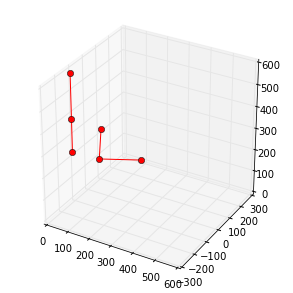

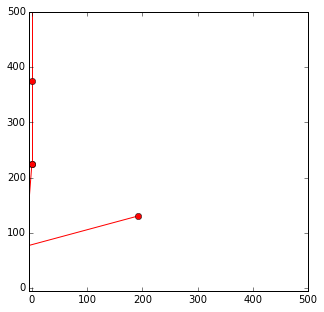

In [16]:
bras_gauche.cinematique_direct(marlien.l_shoulder_y.present_position,marlien.l_elbow_y.present_position,debug=True)
bras_droit.cinematique_direct(marlien.r_shoulder_y.present_position,marlien.r_elbow_y.present_position,debug=True)

Le bras droit est positionné à l'aide d'une autre autre algorythme 
de calcul des coordonnées dans l'espace.

In [17]:
angled = bras_droit.parcours_espace((-180,90),(-90,50),20.0)

temps d'éxécution : 0.456000089645


Le bras droit est positionné en utilisant la méthode de parcours 
globale de tout l'espace.

In [21]:
# on positionne le bras gauche en utilisant la méthode analytique
marlien.r_shoulder_y.goto_position(angled['shoulder_y'],2)
marlien.r_elbow_y.goto_position(angled['elbow_y'],2)

Il existe 3 autres possibilités de parcours de l'espace afin 
d'atteindre la bonne position. L'intérêt de comparer les différentes méthodes est de voir qu'elles n'ont pas toute le même temps d'éxécution. 
Les méthodes présentées sont testé avec seulement 2 degrés de liberté mais à part la méthode analytique qui sera limité à 3 degrés de liberté, les autres méthodes permettent de trouver une position pour un nombre illimité de dof.

In [23]:
@timeit
def test():
    return bras_gauche.descente_cyclique(0,20.0,90,20.0,bras_gauche.f(0,90))
test()

temps d'éxécution : 0.3109998703


{'distance': 110.00142759306782,
 'elbow_y': -19.049007095825647,
 'shoulder_y': 4.276147629849303}

In [24]:
@timeit
def test():
    return bras_gauche.descente_cyclique2(0,90,30.0,bras_gauche.f(0,90))
test()

temps d'éxécution : 0.199000120163


{'distance': 110.00203723072683,
 'elbow_y': -19.13114947726372,
 'shoulder_y': 4.129230133048546}

In [28]:
@timeit
def test():
    return bras_gauche.descente_cyclique_analytique(0,90,bras_gauche.f(0,90))
test()

temps d'éxécution : 0.0639998912811


{'distance': 110.09491993384027,
 'elbow_y': -18.34423477075759,
 'shoulder_y': 3.5658690658520666}

Le robot va maintenant agir sur ces moteurs arm_z afin de presser l'objet entre ses mains. 

In [33]:
marlien.l_arm_z.goto_position(-30,3)
marlien.r_arm_z.goto_position(30,3,wait=True)
marlien.l_arm_z.goto_position(0,1)
marlien.r_arm_z.goto_position(0,1,wait=True)

La classe Courbe va permettre d'analyser la courbe du couple en fonction du temps. Cette courbe ne peut-être obtenu que sur le robot réel car ce sont les moteurs qui renvoit le couple.

In [34]:
class Courbe :
    def lissage(self,nb_points):
        self.temps_lisse=[]
        self.couple_lisse=[]
        l=[]
        for i in self.couple:
            if len(l)<nb_points :
                l.append(i)
            else :
                s=0
                for j in l :
                    s += j
                s = s/nb_points
                self.couple_lisse.append(s)
                l.append(i)
                l.pop(0)

        self.temps_lisse = list(self.temps)
        for i in range(nb_points):
            self.temps_lisse.pop(0)
    
    def __init__(self,temps,couple):
        self.temps = temps
        self.couple = couple
        self.lissage(10)
    
    def etude_croissance(self):
        self.d_couple_lisse=[]
        self.d_temps_lisse=[]
        s = 0
        flag = False
        zone = [0,0]
        n=0
        for i1,t in zip(self.couple_lisse,self.temps_lisse):
            if s == 0 :
                i0 = i1
                s=1
            else :
                d = i1-i0
                self.d_couple_lisse.append(d)
                i0=i1
                self.d_temps_lisse.append(t)
                n+=1
                # recherche de la plus longue periode de croissance
                if flag==False :
                    if d>0 :
                        t0,n0 = t,n
                        flag = True
                else :
                    if d>0 : t1,n1=t,n
                    else : 
                        flag = False
                        if t1-t0 > zone[1]-zone[0] :zone = [t0,t1,n0,n1] 
        return zone
    
    def coef(self):
        s = 0
        zone = self.etude_croissance()
        for i in range(zone[2],zone[2]+25):
            s += self.couple_lisse[i]
        return int(s)
        

Afin d'utiliser les résultats sur le simulateur, des données d'expérimentations obtenues avec le robot réel ont été sauvegardées pour un objet mou et un objet dur. Il suffit de les récupérer pour les utiliser dans le simulateur.

In [35]:
import pickle

In [36]:
with open('mou', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    t_mou = mon_depickler.load()
    
    loadm_mou = mon_depickler.load()

In [37]:
objet_mou = Courbe(t_mou,loadm_mou)

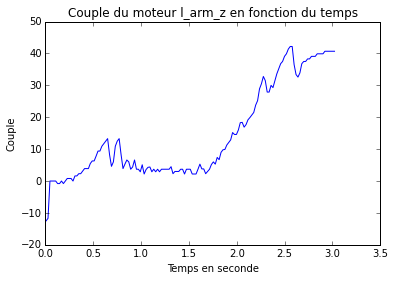

In [38]:
figure(1)            
plot(objet_mou.temps,objet_mou.couple)
xlabel('Temps en seconde')
ylabel('Couple')
title ('Couple du moteur l_arm_z en fonction du temps')

Un lissage de la courbe permet d'éliminer les variations de courte longueur d'onde qui ne nous interesse pas vraiment pour analyser la dureté globale de l'objet.

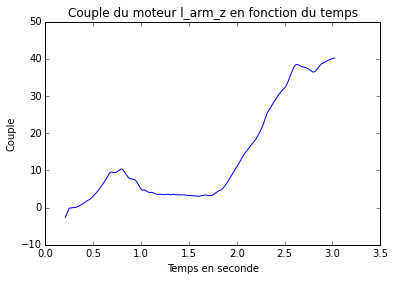

In [39]:
figure(1)            
plot(objet_mou.temps_lisse,objet_mou.couple_lisse)
xlabel('Temps en seconde')
ylabel('Couple')
title ('Couple du moteur l_arm_z en fonction du temps')

Une analyse de la dérivé de la courbe précedente permet de trouver le point de contact entre les mains du robot et l'objet. Ce point de contact permettra de commencer l'analyse de l'augmentation du couple des moteurs. 
L'intégration des valeurs du couple sur une demi seconde aprés le contact avec l'objet permet de donner une bonne estimation de la pression des mains du robot sur l'objet.
Plus le coeficcient de dureté sera élevé plus l'objet aura opposé une résistance au mouvement des mains du robot.

In [42]:
objet_mou.coef()

275

C'est l'analyse de la dérivé de la courbe du couple qui permet de préciser le point d'impact avec les mains (c'est la plus longue zone de couple en croissance).

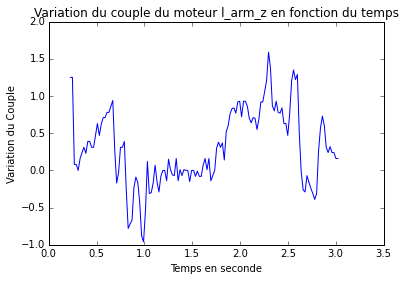

In [43]:
figure(1)            
plot(objet_mou.d_temps_lisse,objet_mou.d_couple_lisse)
xlabel('Temps en seconde')
ylabel('Variation du Couple')
title ('Variation du couple du moteur l_arm_z en fonction du temps')

Les mêmes opérations sont répétées avec un objet dur.

In [44]:
with open('dur', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    td = mon_depickler.load()
    
    loadmd = mon_depickler.load()

In [45]:
objet_dur = Courbe(td,loadmd)

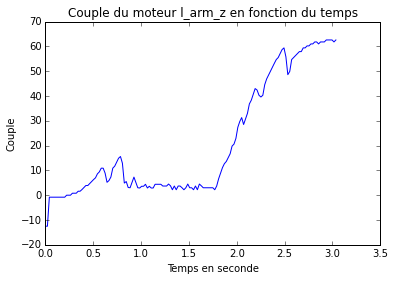

In [46]:
figure(1)            
plot(objet_dur.temps,objet_dur.couple)
xlabel('Temps en seconde')
ylabel('Couple')
title ('Couple du moteur l_arm_z en fonction du temps')

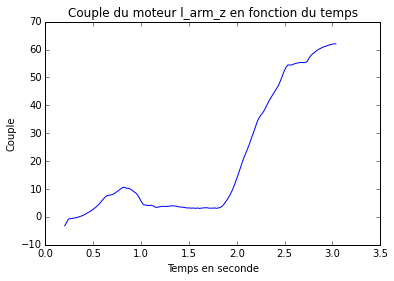

In [47]:
figure(1)            
plot(objet_dur.temps_lisse,objet_dur.couple_lisse)
xlabel('Temps en seconde')
ylabel('Couple')
title ('Couple du moteur l_arm_z en fonction du temps')

In [48]:
objet_dur.coef()

485

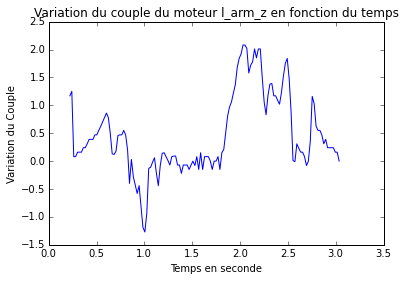

In [49]:
figure(1)            
plot(objet_dur.d_temps_lisse,objet_dur.d_couple_lisse)
xlabel('Temps en seconde')
ylabel('Variation du Couple')
title ('Variation du couple du moteur l_arm_z en fonction du temps')

In [51]:
marlien.reset_simulation()

In [52]:
marlien.close()